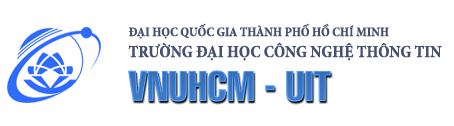



**ĐỒ ÁN CUỐI KỲ MÔN MÁY HỌC - CS114.N21**

---



**BÀI TOÁN: DỰ ĐOÁN GIỚI TÍNH CỦA MỘT NGƯỜI DỰA VÀO HỌ TÊN NGƯỜI ĐÓ**

`Lớp: CS114.N21`

`GV hướng dẫn: TS. Lê Đình Duy, ThS. Phạm Nguyễn Trường An	`

`Thành viên nhóm HKV:`



`1.   Nguyễn Trung Kiên - 21521024`

`2.   Nguyễn Sỹ Hùng - 21522119`

`3.   Phạm Quốc Việt - 21522792`


`Tp. HCM, tháng 7 năm 2023`

**`Mục lục`**

`I. Tổng quan đồ án`

`II. Xây dựng bộ dữ liệu`

`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`

`IV. Kết luận`



##**`I. Tổng quan đồ án`**

###`1.1. Mô tả bài toán`

`Đề tài dự đoán giới tính một người dựa vào họ tên là đề tài hướng đến việc sử dụng họ và tên của một người để có thể phân loại người đó là nam hay nữ. Trong Machine Learning, đây là dạng bài toán có tên gọi Binary Classification, trong đó bài toán chỉ có hai classes, cũng là hai giới tính cần được phân loại.`

###**`1.2. Input và output của bài toán`**

`- Input: Dataset bao gồm họ và tên và giới tính tương ứng`

`- Output: Họ và tên người cần dự đoán và giới tính được dự đoán của người đó`

###**`1.3. Các thuật toán máy học mà đồ án sử dụng`**

`Trong bài báo cáo, nhóm sẽ sử dụng 4 mô hình classification, đó là: Logistics Regression, SVM, Gaussian Naive Bayes và Decision Tree. Sau khi qua các bước xử lý dữ liệu và trích chọn đặc trưng, data được xử lý sẽ đưa vào các mô hình classification và sau cùng đánh giá từng mô hình bằng confusion matrix và giá trị của các metrics: accuracy, precision, recall và f1-score.`

###**`1.4. Các tiêu chí về một mô hình được đánh giá tốt`**

`2 tiêu chí mà nhóm sử dụng để đánh giá một mô hình có thể xem là tốt đó là:`

`- f1-score cao: f1- score là giá trị trung bình điều hòa của precision và recall. Hiểu một cách đơn giản, f1-score cân bằng hai giá trị precision và recall. Đôi khi trong một số trường hợp, tập dữ liệu quá nghiêng về trường hợp positive, giá trị precision sẽ cao nhưng recall thấp, và ngược lại. Hiện tượng này thường được đề cập với tên gọi precision-recall trade-off. Do đó, để tránh việc này, f1-score phải cao thì mới tương ứng với precision cao và recall cao. Nhóm hi vọng f1-score của nhóm đạt trên 90%.`

`- Confusion matrix: Mô hình tốt là khi confusion matrix có giá trị lớn (đậm đặc về màu sắc) trên đường chéo chính của nó, cho thấy các điểm dữ liệu đã được phân loại đúng là lớn.`  


##**`II. Xây dựng bộ dữ liệu`**

`Trước tiên, nhóm sẽ khai báo các package cần thiết sẽ sử dụng cho bài toán như sau: `



In [ ]:
!pip install transformers
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, logging
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

`Đọc file json lấy từ dataset của nhóm trên github`

In [ ]:
data = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/Final_dataset.json")
print(data)

                full_name  gender
0           Ngô Xuân Tùng       1
1       Bùi Dương Thảo Vy       0
2             Lưu Thế Huy       1
3          Nguyễn Thị Vân       0
4         Dương Minh Long       1
...                   ...     ...
28796    Huỳnh Thu Phương       0
28797      Mai Nguyệt Lan       0
28798       Hà Thanh Ngân       0
28799  Phan Thị Tuyết Nhi       0
28800    Vũ Hoàng Thúy Vy       0

[28801 rows x 2 columns]


`Mô tả về bộ dataset`

`- Số lượng nam, nữ giới và còn lại trong bộ data lần lượt là: 16613, 12188 và 0, số lượng nam và nữ giới trong dataset gần bằng nhau để phần nào tránh được tình trạng information bias`

In [ ]:
#Number of males, females and others in data, and the length of data
male = 0
female = 0
other = 0
for line in data["gender"]:
  if line == 1:
    male += 1
  elif line == 0:
    female += 1
  else:
    print(line)
    other += 1
print("Number of males, females and others in data: %s, %s, %s" % (male, female, other))
print("Length of data: %s" % len(data["gender"]))

Number of males, females and others in data: 16613, 12188, 0
Length of data: 28801


`Số lượng họ và tên không trùng trong dataset được lọc ra là 19431. Việc lọc bỏ các dữ liệu trùng lặp cũng sẽ tránh việc information bias. Sau cùng, ta được data chứa một bộ các họ và tên không có bất kỳ bộ đôi họ và tên nào trùng lặp với nhau`

In [ ]:
name_counts = data['full_name'].value_counts()
unique_names = name_counts[name_counts == 1].index
data = data[data['full_name'].isin(unique_names)]
print(data)

                  full_name  gender
1         Bùi Dương Thảo Vy       0
2               Lưu Thế Huy       1
4           Dương Minh Long       1
5            Trần Mai Khanh       0
6      Nguyễn Thị Hồng Diệp       0
...                     ...     ...
28794    Phạm Đoàn Bảo Châu       0
28796      Huỳnh Thu Phương       0
28797        Mai Nguyệt Lan       0
28798         Hà Thanh Ngân       0
28800      Vũ Hoàng Thúy Vy       0

[19431 rows x 2 columns]


`Tách data ra làm 2 phần: X tương ứng với họ và tên và y tương ứng với giá trị đã quy định cho giới tính, 0 là nữ giới, và 1 ứng với nam giới`

In [ ]:
X = data["full_name"]
y = data["gender"]

In [ ]:
print(X)

1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
4             Dương Minh Long
5              Trần Mai Khanh
6        Nguyễn Thị Hồng Diệp
                 ...         
28794      Phạm Đoàn Bảo Châu
28796        Huỳnh Thu Phương
28797          Mai Nguyệt Lan
28798           Hà Thanh Ngân
28800        Vũ Hoàng Thúy Vy
Name: full_name, Length: 19431, dtype: object


In [ ]:
print(y)

1        0
2        1
4        1
5        0
6        0
        ..
28794    0
28796    0
28797    0
28798    0
28800    0
Name: gender, Length: 19431, dtype: int64


##**`III. Áp dụng các mô hình máy học và trích chọn đặc trưng`**

`Trước tiên, ta chia dữ liệu để xử lý các bước kế tiếp, tỉ lệ 80/20 tương ứng với data để train và data để test`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


####`3.1. Áp dụng PhoBERT`

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

{'input_ids': tensor([[    0,  3212,  2521,  ...,     1,     1,     1],
        [    0,  3751,  8224,  ...,     1,     1,     1],
        [    0, 34811,  1962,  ...,     1,     1,     1],
        ...,
        [    0,  1955,  1612,  ...,     1,     1,     1],
        [    0, 34811,  1858,  ...,     1,     1,     1],
        [    0,  4267,  2965,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

`Sau khi đưa qua mô hình PhoBERT, data có dạng text mà ta có lúc đầu đã được convert về dạng numpy array, lúc này là đủ để sử dụng mô hình máy học`

In [ ]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


`Sử dụng Logistic Regression`

In [ ]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model

print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1655
           1       0.92      0.96      0.94      2232

    accuracy                           0.93      3887
   macro avg       0.93      0.93      0.93      3887
weighted avg       0.93      0.93      0.93      3887

F1-score of using logistic regression: 0.9422066549912435


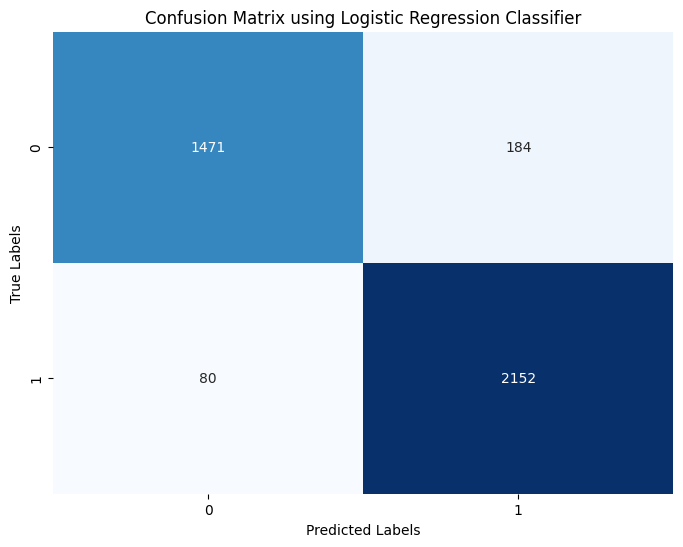

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Logistic Regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      1655
           1       0.92      0.97      0.94      2232

    accuracy                           0.93      3887
   macro avg       0.94      0.93      0.93      3887
weighted avg       0.93      0.93      0.93      3887

F1-score of using SVM model: 0.9430929626411815


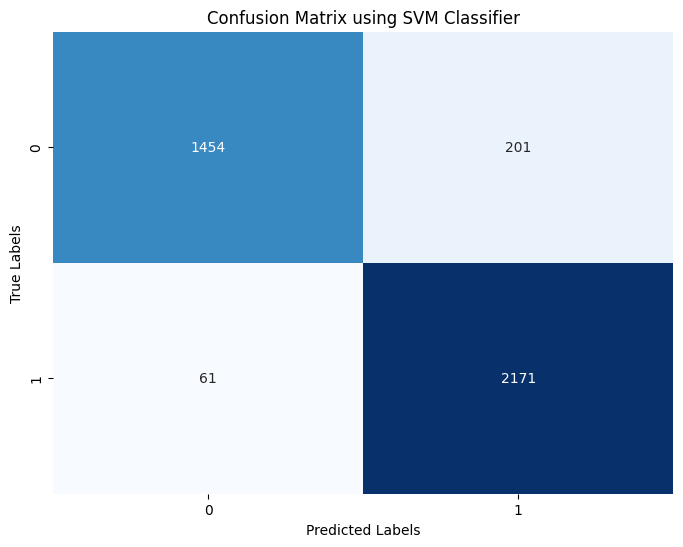

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng Gaussian Naive Bayes`

In [ ]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using GaussianNB model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1655
           1       0.88      0.97      0.92      2232

    accuracy                           0.91      3887
   macro avg       0.92      0.89      0.90      3887
weighted avg       0.91      0.91      0.90      3887

F1-score of using GaussianNB model: 0.9220972192740394


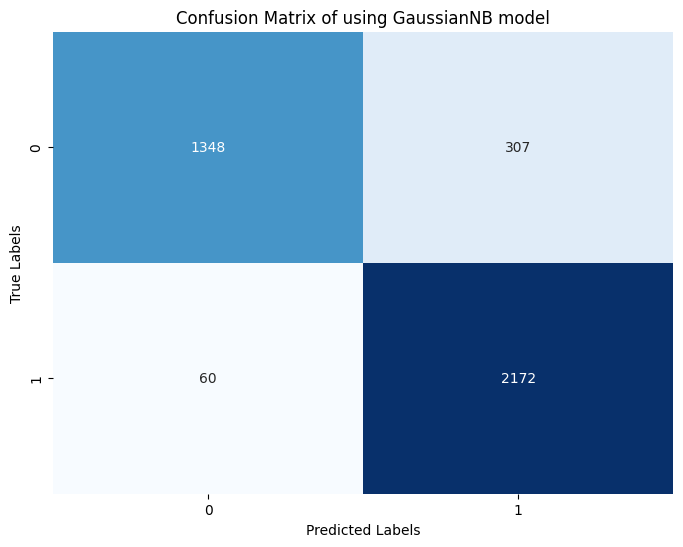

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng Decision Tree`

In [ ]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of using DecisionTreeClassifier:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1655
           1       0.84      0.85      0.85      2232

    accuracy                           0.82      3887
   macro avg       0.82      0.82      0.82      3887
weighted avg       0.82      0.82      0.82      3887

Accuracy of using DecisionTreeClassifier: 0.8242860818111655


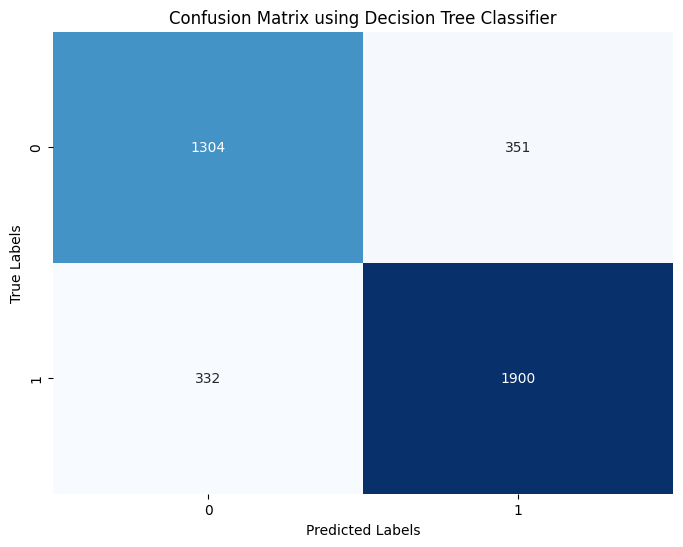

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Hàm separate_full_name nhằm trả về tên đệm và tên của một người. Trường hợp không có tên đệm thì ta trả về tên đệm là một chuỗi rỗng`

In [15]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [16]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Một lần nữa, áp dụng các mô hình máy học sau đó đánh giá`

In [17]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train, X_test, y_train, y_test = train_test_split(X_erase_surname, y, test_size=0.2, random_state=42)
X_train_encoded = tokenizer.batch_encode_plus(
    X_train,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens

{'input_ids': tensor([[    0,  2521, 13201,  ...,     1,     1,     1],
        [    0,  3019,  8517,  ...,     1,     1,     1],
        [    0,  2883,  6984,  ...,     1,     1,     1],
        ...,
        [    0,  1612, 23131,  ...,     1,     1,     1],
        [    0,  6739,   590,  ...,     1,     1,     1],
        [    0,  1827, 15512,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [18]:
# Pass the encoded inputs through the PhoBERT model
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

In [19]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


In [20]:
# 1. Train a logistic regression model
lr_model = LogisticRegression(max_iter=10000000)
lr_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1655
           1       0.89      0.94      0.92      2232

    accuracy                           0.90      3887
   macro avg       0.90      0.89      0.90      3887
weighted avg       0.90      0.90      0.90      3887

F1-score of using logistic regression: 0.9162475399081565


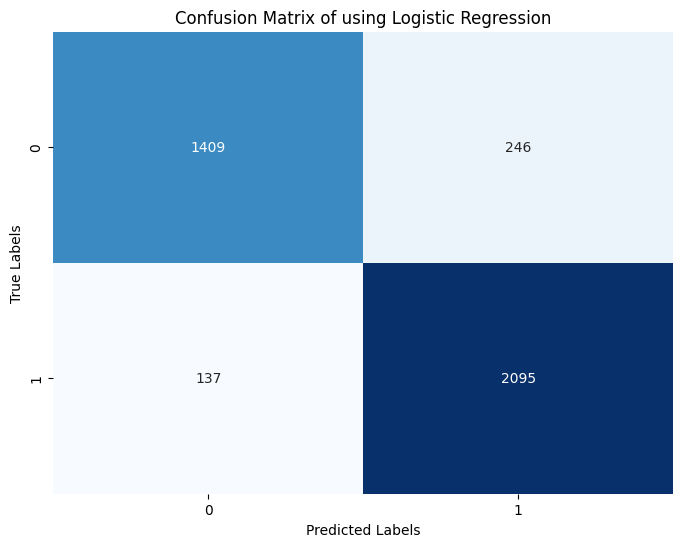

In [21]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [22]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1655
           1       0.90      0.95      0.92      2232

    accuracy                           0.91      3887
   macro avg       0.91      0.90      0.91      3887
weighted avg       0.91      0.91      0.91      3887

F1-score of using SVM model: 0.9227421109902068


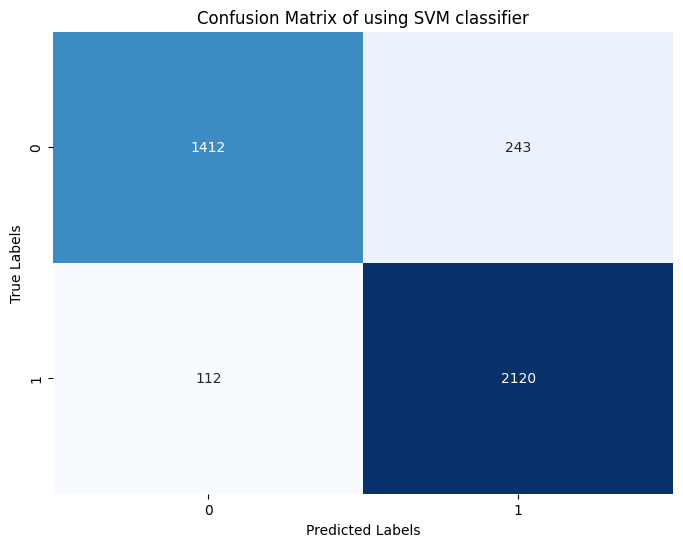

In [23]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
# 3. Train a Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_embeddings, y_train)
# Predict on the test set
y_pred = nb_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using GaussianNB model:", f1_score(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1655
           1       0.85      0.86      0.86      2232

    accuracy                           0.83      3887
   macro avg       0.83      0.83      0.83      3887
weighted avg       0.83      0.83      0.83      3887

F1-score of using GaussianNB model: 0.8550466874166296


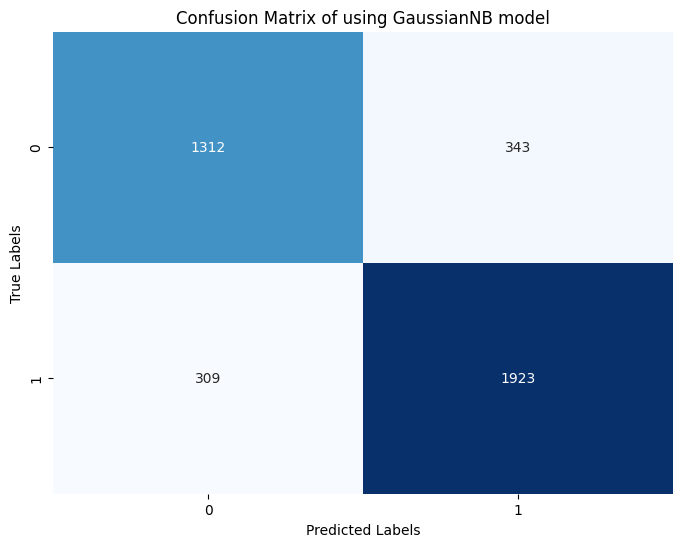

In [25]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using GaussianNB model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [26]:
#4. Train a Decision Tree Classifier model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = tree_model.predict(X_test_embeddings)

# Evaluate the model
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of using DecisionTreeClassifier:", accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.82      0.83      0.83      1655
           1       0.87      0.87      0.87      2232

    accuracy                           0.85      3887
   macro avg       0.85      0.85      0.85      3887
weighted avg       0.85      0.85      0.85      3887

Accuracy of using DecisionTreeClassifier: 0.8528428093645485


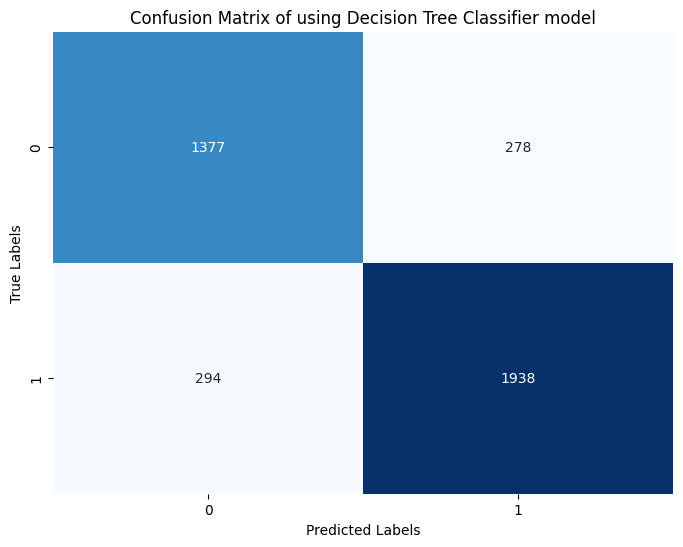

In [27]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#### `3.2. Bag of words (BoW)`

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
X = data['full_name']
y = data['gender']

In [30]:
processed_names = []
for name in X:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

`Xây dựng từ điển từ các từ trong tên đầy đủ`

In [31]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [32]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1575
Vocabualry content:
 {} {'bùi': 59, 'dương': 234, 'thảo': 1156, 'vy': 1404, 'lưu': 588, 'thế': 1169, 'huy': 315, 'minh': 632, 'long': 540, 'trần': 1271, 'mai': 624, 'khanh': 440, 'nguyễn': 711, 'thị': 1172, 'hồng': 404, 'diệp': 204, 'thi': 1078, 'ngọc': 728, 'thái': 1119, 'tường': 1335, 'lê': 568, 'trúc': 1256, 'quỳnh': 967, 'ngô': 720, 'đức': 1564, 'hoàng': 309, 'tấn': 1343, 'đào': 1505, 'hiếu': 290, 'thạch': 1150, 'kim': 473, 'yến': 1459, 'võ': 1411, 'thanh': 1073, 'phạm': 884, 'lệ': 608, 'chi': 105, 'đỗ': 1559, 'nghĩa': 696, 'đinh': 1485, 'dân': 224, 'huỳnh': 330, 'lý': 580, 'chương': 131, 'lương': 589, 'việt': 1396, 'xuân': 1451, 'trịnh': 1278, 'nhật': 784, 'trung': 1238, 'tiến': 1199, 'đạt': 1527, 'giàu': 263, 'mỹ': 678, 'linh': 528, 'phúc': 878, 'trang': 1223, 'hồ': 400, 'nhơn': 772, 'anh': 6, 'duy': 212, 'ngôn': 722, 'cao': 95, 'thiện': 1089, 'huân': 323, 'đình': 1509, 'trương': 1260, 'diệu': 205, 'hiền': 291, 'giang': 257, 'đại': 1524, 'thu': 1101, 'thủ

`Chia bộ dữ liệu thành tập huấn luyện và tập kiểm tra`

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X)

  (0, 59)	1
  (0, 234)	1
  (0, 1156)	1
  (0, 1404)	1
  (1, 588)	1
  (1, 1169)	1
  (1, 315)	1
  (2, 234)	1
  (2, 632)	1
  (2, 540)	1
  (3, 1271)	1
  (3, 624)	1
  (3, 440)	1
  (4, 711)	1
  (4, 1172)	1
  (4, 404)	1
  (4, 204)	1
  (5, 1078)	1
  (5, 728)	1
  (5, 1119)	1
  (6, 1404)	1
  (6, 624)	1
  (6, 711)	1
  (6, 1335)	1
  (7, 568)	1
  :	:
  (19424, 711)	1
  (19424, 1073)	1
  (19424, 1185)	1
  (19424, 1197)	1
  (19425, 1172)	1
  (19425, 728)	1
  (19425, 568)	1
  (19425, 556)	1
  (19426, 884)	1
  (19426, 1498)	1
  (19426, 74)	1
  (19426, 124)	1
  (19427, 330)	1
  (19427, 1101)	1
  (19427, 880)	1
  (19428, 624)	1
  (19428, 519)	1
  (19428, 713)	1
  (19429, 1073)	1
  (19429, 718)	1
  (19429, 353)	1
  (19430, 1404)	1
  (19430, 309)	1
  (19430, 1416)	1
  (19430, 1137)	1


`Huấn luyện mô hình Logistic Regression`

In [35]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1655
           1       0.94      0.97      0.95      2232

    accuracy                           0.94      3887
   macro avg       0.94      0.94      0.94      3887
weighted avg       0.94      0.94      0.94      3887

F1-score of using logistic regression: 0.9512679162072768


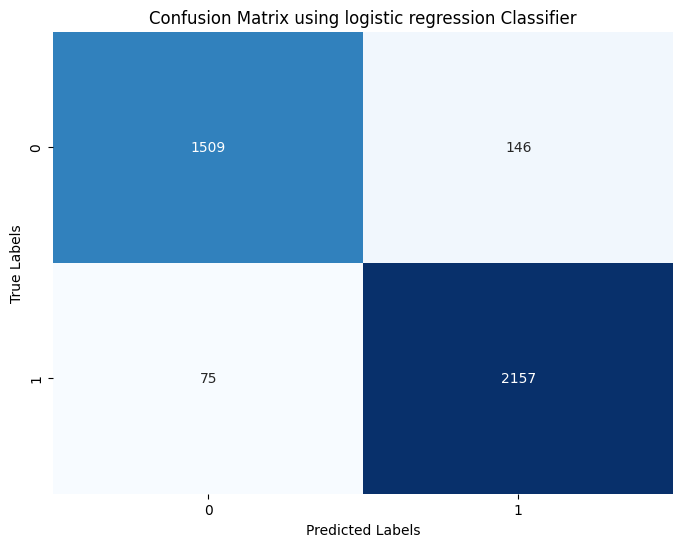

In [37]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình SVM`

In [38]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, svm_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1655
           1       0.94      0.97      0.95      2232

    accuracy                           0.94      3887
   macro avg       0.94      0.94      0.94      3887
weighted avg       0.94      0.94      0.94      3887

F1-score of using SVM model: 0.9499121265377855


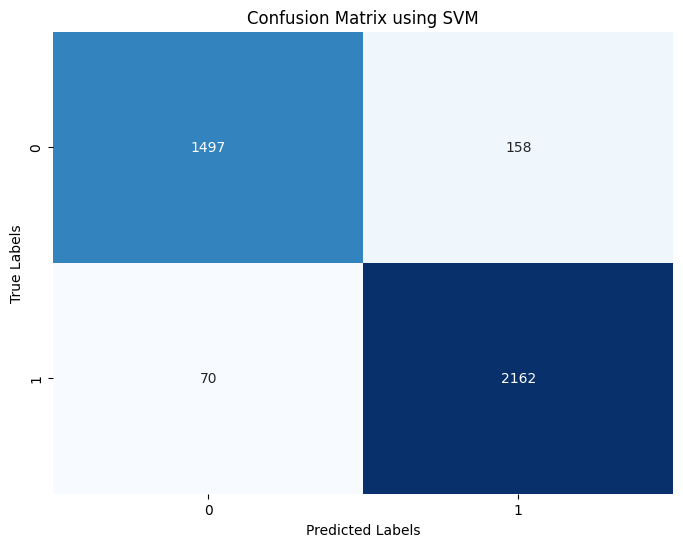

In [39]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình Decision Tree`

In [40]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [41]:
print(classification_report(y_test, dt_pred))
print("F1-score of using Decision Tree:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1655
           1       0.92      0.92      0.92      2232

    accuracy                           0.91      3887
   macro avg       0.90      0.90      0.90      3887
weighted avg       0.91      0.91      0.91      3887

F1-score of using Decision Tree: 0.9512679162072768


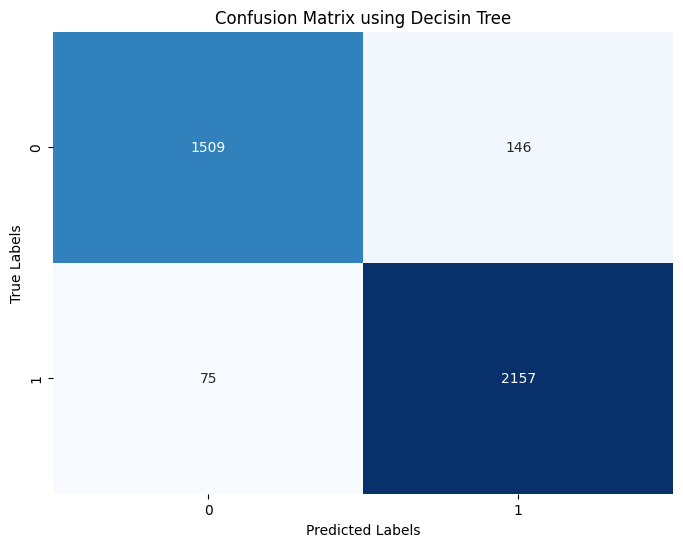

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decisin Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình Gaussian Naive Bayes`

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes :", f1_score(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1655
           1       0.94      0.97      0.95      2232

    accuracy                           0.94      3887
   macro avg       0.94      0.94      0.94      3887
weighted avg       0.94      0.94      0.94      3887

F1-score of using Gaussian Naive Bayes : 0.5


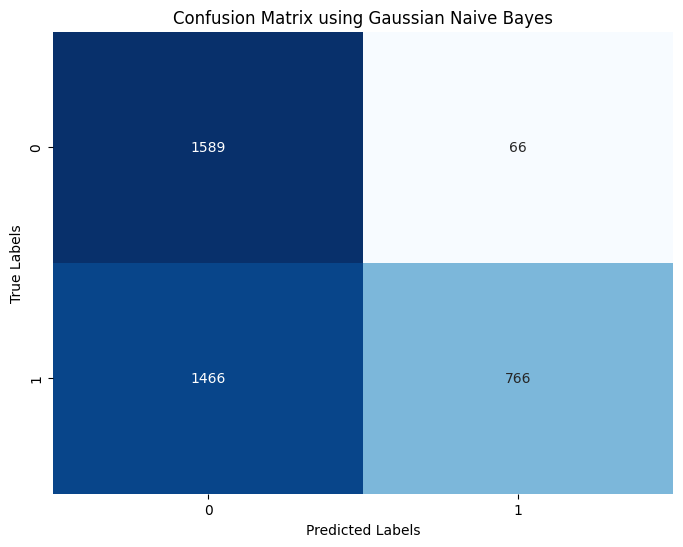

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Tách họ ra khỏi họ và tên trong dataset, ta được kết quả như sau`

In [ ]:
#Split function to take away the surname
def separate_full_name(full_name):
    fname = full_name.split()
    name = ""
    middle_name = ""
    surname = ""
    if len(fname) > 2:
      name = fname[len(fname) - 1]
      surname = fname[len(fname) - 3]
      middle_name = fname[len(fname) - 2]
    elif len(fname) == 2:
      name = fname[1]
      middle_name = ""
      surname = ""
    return middle_name, name

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

In [ ]:
y = data['gender']

In [ ]:
processed_names = []
for name in X_erase_surname:
    # Tách từ và loại bỏ ký tự đặc biệt
    processed_name = ' '.join(word.lower() for word in name.split() if word.isalpha())
    processed_names.append(processed_name)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_names)

In [ ]:
print("Vocabulary size: {}", format(len(vectorizer.vocabulary_)))
print("Vocabualry content:\n {}", format(vectorizer.vocabulary_))

Vocabulary size: {} 1284
Vocabualry content:
 {} {'thảo': 935, 'vy': 1147, 'thế': 947, 'huy': 268, 'minh': 506, 'long': 437, 'mai': 500, 'khanh': 354, 'hồng': 331, 'diệp': 166, 'ngọc': 586, 'thái': 901, 'tường': 1090, 'trúc': 1020, 'quỳnh': 775, 'đức': 1276, 'tấn': 1097, 'hiếu': 246, 'kim': 383, 'yến': 1195, 'thị': 950, 'thanh': 858, 'lệ': 490, 'chi': 82, 'nghĩa': 556, 'dân': 185, 'chương': 103, 'việt': 1141, 'xuân': 1188, 'nhật': 640, 'trung': 1005, 'tiến': 973, 'đạt': 1250, 'giàu': 223, 'mỹ': 542, 'linh': 426, 'phúc': 716, 'trang': 993, 'nhơn': 628, 'anh': 4, 'duy': 174, 'ngôn': 581, 'thiện': 872, 'huân': 276, 'đình': 1233, 'diệu': 167, 'hiền': 247, 'đại': 1247, 'thu': 884, 'thủy': 962, 'khảo': 376, 'xương': 1190, 'tú': 1079, 'sec': 806, 'váy': 1150, 'huỳnh': 283, 'duyên': 175, 'uyên': 1120, 'nam': 545, 'thiên': 864, 'phước': 719, 'tùng': 1078, 'phong': 700, 'như': 629, 'quí': 764, 'quang': 749, 'hào': 296, 'thành': 900, 'bích': 41, 'dũng': 191, 'công': 129, 'triều': 1000, 'phương': 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
print(classification_report(y_test, y_pred))
print("F1-score of using logistic regression:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1655
           1       0.92      0.95      0.93      2232

    accuracy                           0.92      3887
   macro avg       0.92      0.92      0.92      3887
weighted avg       0.92      0.92      0.92      3887

F1-score of using logistic regression: 0.9313617303023615


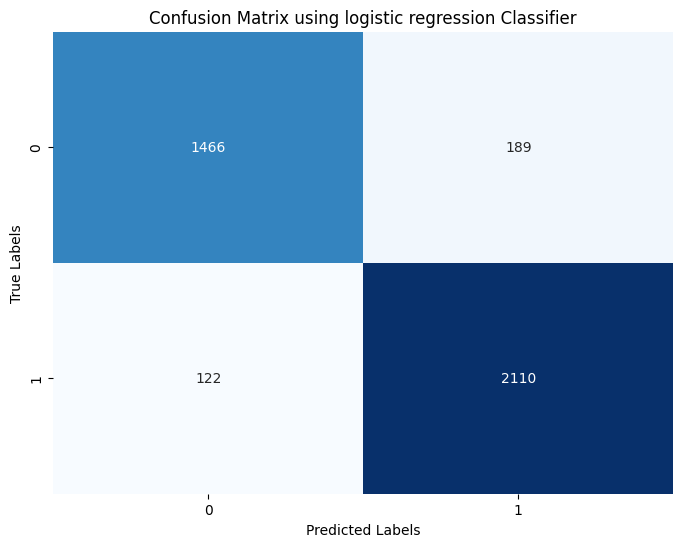

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using logistic regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình SVM`

In [ ]:
#2. Train a SVM classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Predict on the test set
svm_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("F1-score of using SVM model:", f1_score(y_test, svm_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, svm_pred)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1655
           1       0.92      0.95      0.93      2232

    accuracy                           0.92      3887
   macro avg       0.92      0.92      0.92      3887
weighted avg       0.92      0.92      0.92      3887

F1-score of using SVM model: 0.928335170893054


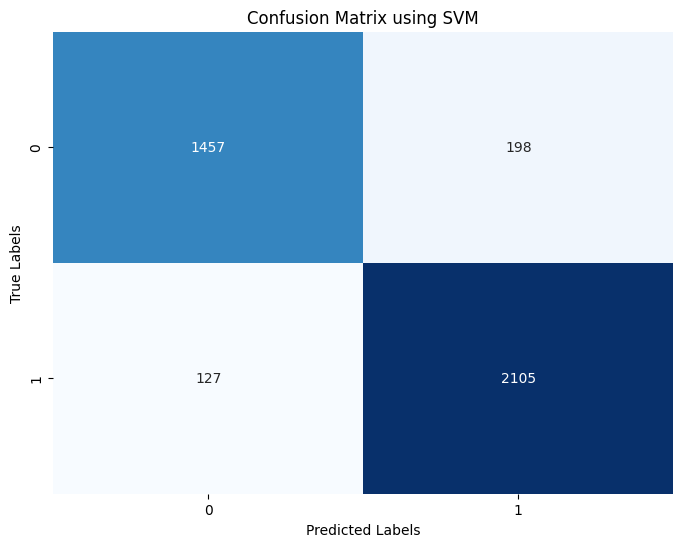

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình Decision Tree`

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
dt_pred = tree_model.predict(X_test)

In [ ]:
print(classification_report(y_test, dt_pred))
print("F1-score of using Decision Tree:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1655
           1       0.91      0.88      0.89      2232

    accuracy                           0.88      3887
   macro avg       0.88      0.88      0.88      3887
weighted avg       0.88      0.88      0.88      3887

F1-score of using Decision Tree: 0.9313617303023615


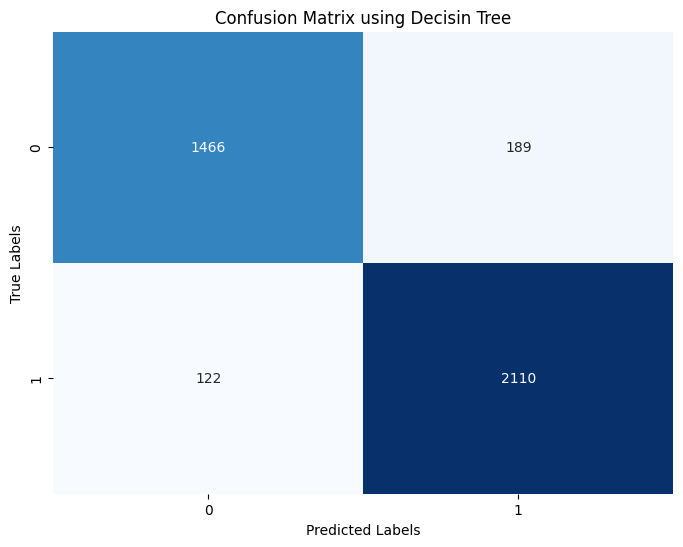

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Decisin Tree")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Huấn luyện mô hình Gaussian Naive Bayes`

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train.toarray(), y_train)
nb_pred = nb_model.predict(X_test.toarray())

In [ ]:
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes :", f1_score(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1655
           1       0.92      0.95      0.93      2232

    accuracy                           0.92      3887
   macro avg       0.92      0.92      0.92      3887
weighted avg       0.92      0.92      0.92      3887

F1-score of using Gaussian Naive Bayes : 0.49007936507936506


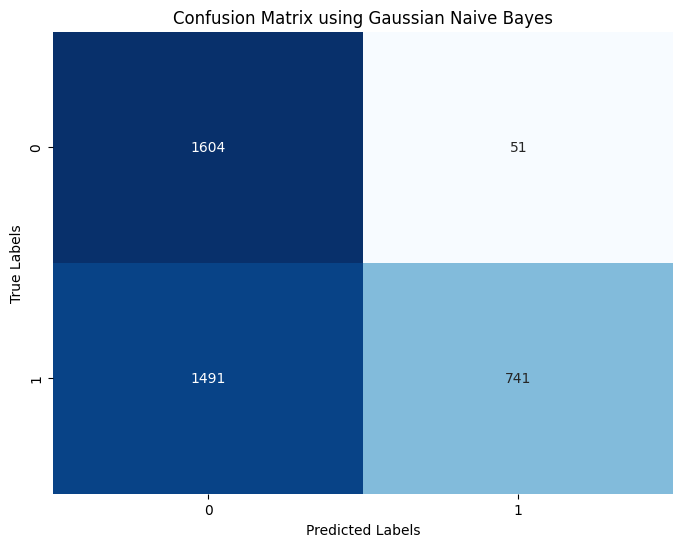

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.3. Bag of n-grams`

In [ ]:
X = data["full_name"]
y = data["gender"]

`Bag of n-grams là một mô hình tương tự như Bag of Words, chỉ khác một điều là mô hình này là một tập hợp các cụm phần tử có chuỗi n phần tử liền kề với nhau từ một văn bản cho trước. Nếu n = 1 (unigram) thì ta có thể xem đây là bag of words. Các phần tử có thể là các từ, chữ cái, âm tiết,...`

`Ví dụ: ta có một câu như sau: "Xin chào thế giới."`

`Với unigram (n = 1): "Xin", "chào", "thế", "giới"`

`Với bigram (n = 2): "Xin chào", "chào thế", "thế giới"`
`Với trigram (n = 3): "Xin chào thế", "chào thế giới"`



`Trong thư viện sklearn.feature_extraction.text có một hàm là CountVectorizer(), ta dùng hàm này để áp dụng mô hình Bag of n-grams cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

`Ta dùng hàm CountVectorizer() với ngram_range=(2, 3)) - n thuộc khoảng từ 2 -> 3`

In [ ]:
cv = CountVectorizer(ngram_range=(2, 3))

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [ ]:
X_convert = cv.fit_transform(np.array(X))

`Hiển thị từ điển cụm từ`

In [ ]:
print(cv.vocabulary_)

{'bùi dương': 570, 'dương thảo': 3165, 'thảo vy': 22305, 'bùi dương thảo': 574, 'dương thảo vy': 3167, 'lưu thế': 10450, 'thế huy': 22361, 'lưu thế huy': 10451, 'dương minh': 3017, 'minh long': 11429, 'dương minh long': 3025, 'trần mai': 26768, 'mai khanh': 11054, 'trần mai khanh': 26771, 'nguyễn thị': 14469, 'thị hồng': 23019, 'hồng diệp': 6530, 'nguyễn thị hồng': 14533, 'thị hồng diệp': 23025, 'thi ngọc': 21253, 'ngọc thái': 16798, 'thi ngọc thái': 21254, 'nguyễn mai': 13405, 'mai tường': 11257, 'tường vy': 28873, 'nguyễn mai tường': 13423, 'mai tường vy': 11258, 'lê trúc': 9588, 'trúc quỳnh': 25523, 'lê trúc quỳnh': 9590, 'ngô minh': 15957, 'minh đức': 11633, 'ngô minh đức': 15980, 'hoàng ngọc': 3977, 'ngọc tấn': 16911, 'hoàng ngọc tấn': 4001, 'đào minh': 33022, 'minh hiếu': 11371, 'đào minh hiếu': 33023, 'thạch thị': 22216, 'thị kim': 23151, 'kim yến': 7528, 'thạch thị kim': 22221, 'thị kim yến': 23263, 'võ thị': 30104, 'thị thanh': 24079, 'võ thị thanh': 30157, 'phạm thị': 19596, 

`Làm quen với X đã được chuyển đổi`

In [ ]:
print(X_convert)

  (0, 570)	1
  (0, 3165)	1
  (0, 22305)	1
  (0, 574)	1
  (0, 3167)	1
  (1, 10450)	1
  (1, 22361)	1
  (1, 10451)	1
  (2, 3017)	1
  (2, 11429)	1
  (2, 3025)	1
  (3, 26768)	1
  (3, 11054)	1
  (3, 26771)	1
  (4, 14469)	1
  (4, 23019)	1
  (4, 6530)	1
  (4, 14533)	1
  (4, 23025)	1
  (5, 21253)	1
  (5, 16798)	1
  (5, 21254)	1
  (6, 13405)	1
  (6, 11257)	1
  (6, 28873)	1
  :	:
  (19424, 21146)	1
  (19425, 9390)	1
  (19425, 23697)	1
  (19425, 9464)	1
  (19425, 16584)	1
  (19425, 23746)	1
  (19426, 1167)	1
  (19426, 32540)	1
  (19426, 19947)	1
  (19426, 19948)	1
  (19426, 32541)	1
  (19427, 21488)	1
  (19427, 5074)	1
  (19427, 5078)	1
  (19428, 11093)	1
  (19428, 15797)	1
  (19428, 11094)	1
  (19429, 5596)	1
  (19429, 21058)	1
  (19429, 5602)	1
  (19430, 22133)	1
  (19430, 31117)	1
  (19430, 4145)	1
  (19430, 31129)	1
  (19430, 4148)	1


`Chia data thành 80% bộ train và 20% bộ test`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42)

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1655
           1       0.84      0.98      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.90      0.86      0.87      3887
weighted avg       0.89      0.88      0.88      3887

F1-score of using SVM: 0.904408735063865


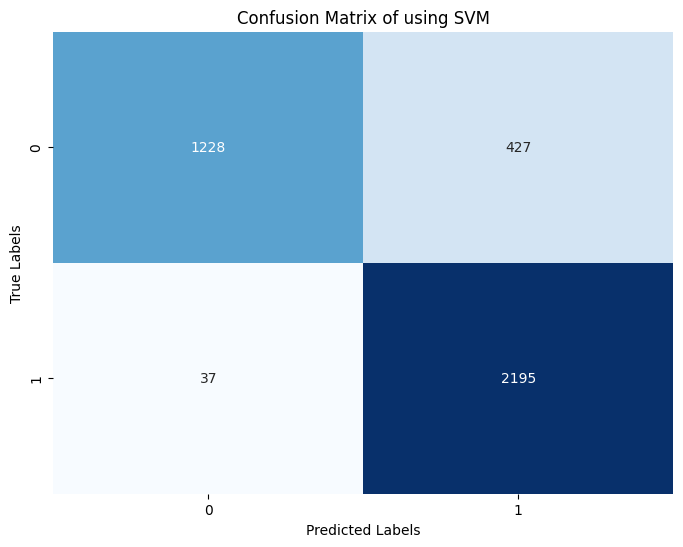

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1655
           1       0.84      0.99      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.91      0.86      0.87      3887
weighted avg       0.90      0.88      0.88      3887

F1-score of using Logistic Regression: 0.9048304213771841


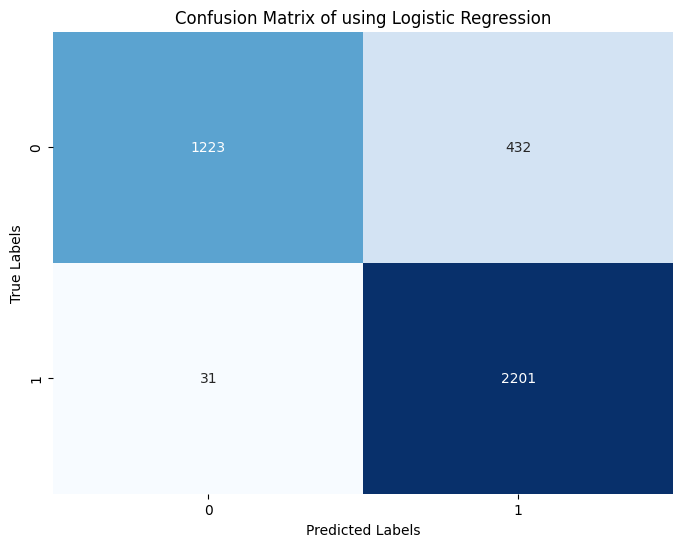

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1655
           1       0.96      0.69      0.80      2232

    accuracy                           0.80      3887
   macro avg       0.83      0.82      0.80      3887
weighted avg       0.85      0.80      0.80      3887

F1-score of using Gaussian Naive Bayes: 0.8015645371577574


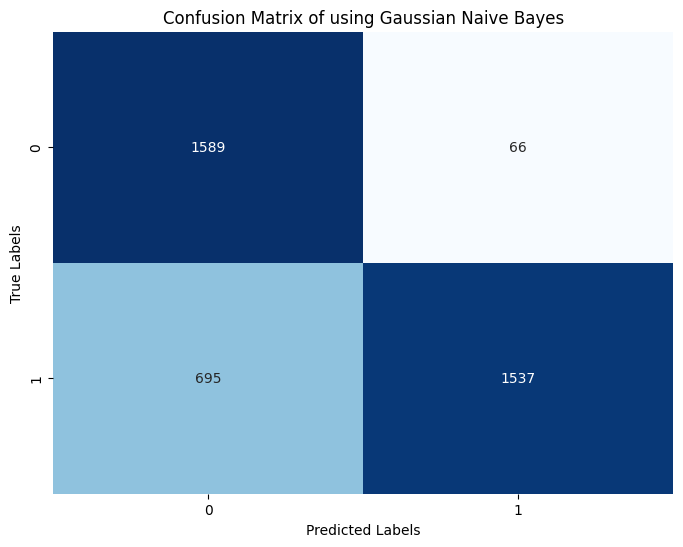

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1655
           1       0.85      0.96      0.90      2232

    accuracy                           0.88      3887
   macro avg       0.89      0.87      0.87      3887
weighted avg       0.89      0.88      0.88      3887

F1-score of using Decision Tree Classifier: 0.9024236037934668


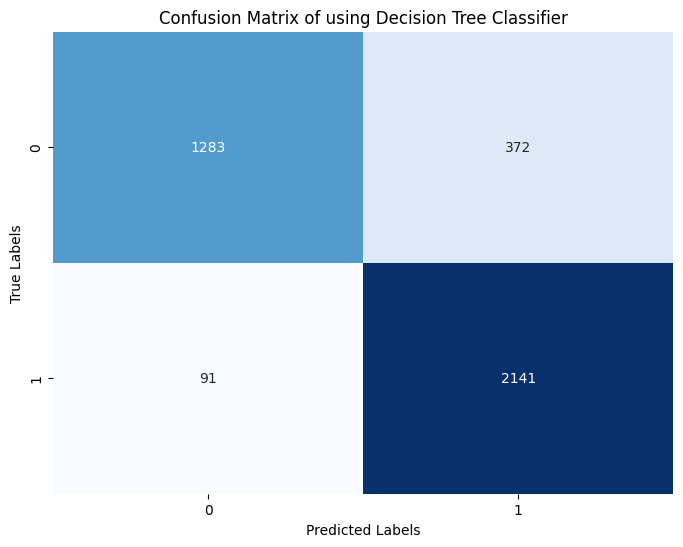

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Áp dụng các bước bag of n-grams đã trình bày ở phía trên, tổng hợp lại được đoạn code sau:`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
cv = CountVectorizer(ngram_range=(2, 3))
X_convert = cv.fit_transform(np.array(X_erase_surname))
cv.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(X_convert, y, test_size=0.2, random_state=42)

`SVM`

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1655
           1       0.79      0.97      0.87      2232

    accuracy                           0.83      3887
   macro avg       0.86      0.81      0.82      3887
weighted avg       0.85      0.83      0.82      3887

F1-score of using SVM: 0.8675230830991569


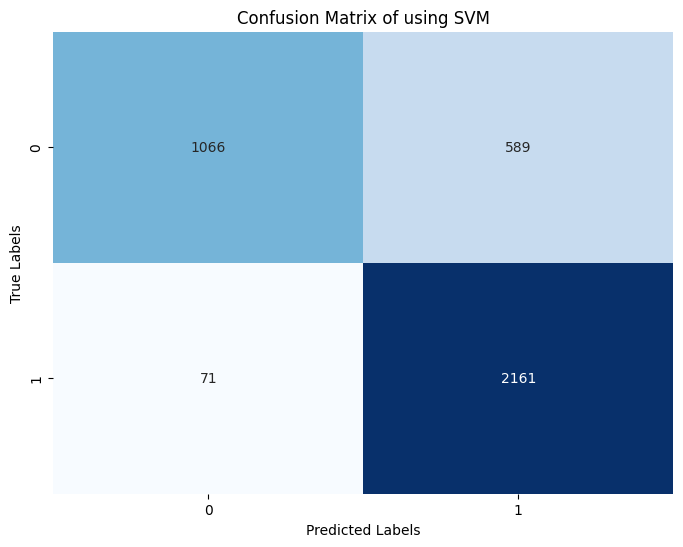

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Logistic Regression`

              precision    recall  f1-score   support

           0       0.94      0.64      0.76      1655
           1       0.79      0.97      0.87      2232

    accuracy                           0.83      3887
   macro avg       0.86      0.81      0.82      3887
weighted avg       0.85      0.83      0.82      3887

F1-score of using Logistic Regression: 0.8675230830991569


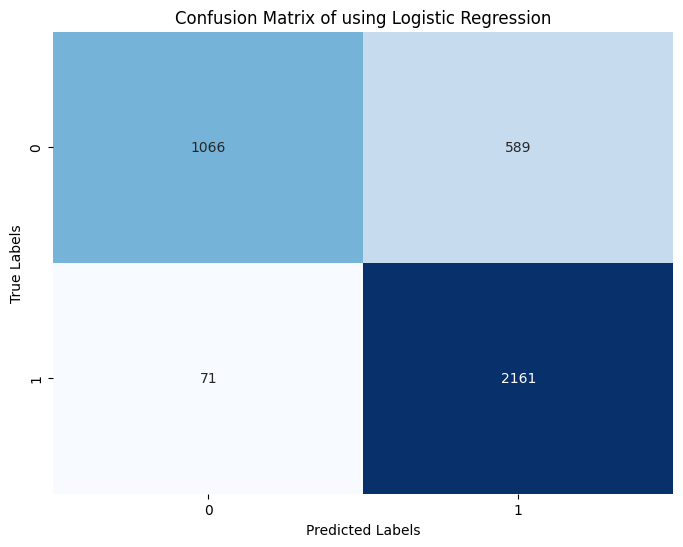

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0       0.60      0.97      0.74      1655
           1       0.96      0.51      0.67      2232

    accuracy                           0.71      3887
   macro avg       0.78      0.74      0.70      3887
weighted avg       0.80      0.71      0.70      3887

F1-score of using Gaussian Naive Bayes: 0.6660813579163009


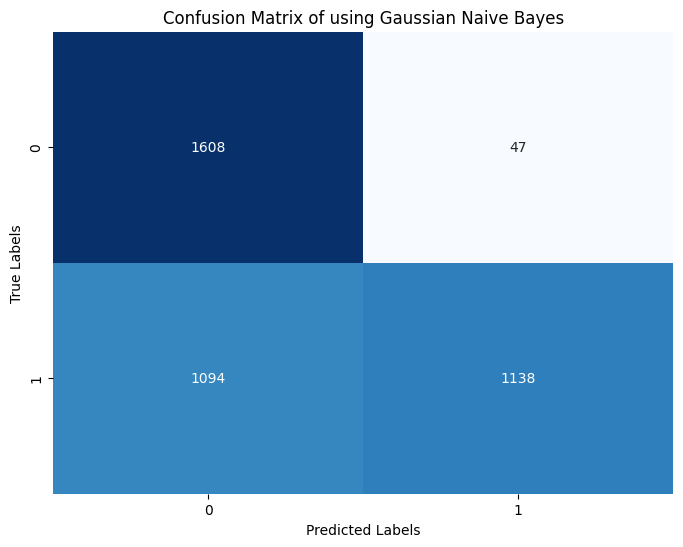

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Decision Tree Classifier`

              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1655
           1       0.79      0.96      0.87      2232

    accuracy                           0.83      3887
   macro avg       0.85      0.81      0.82      3887
weighted avg       0.84      0.83      0.82      3887

F1-score of using Decision Tree Classifier: 0.8654781199351703


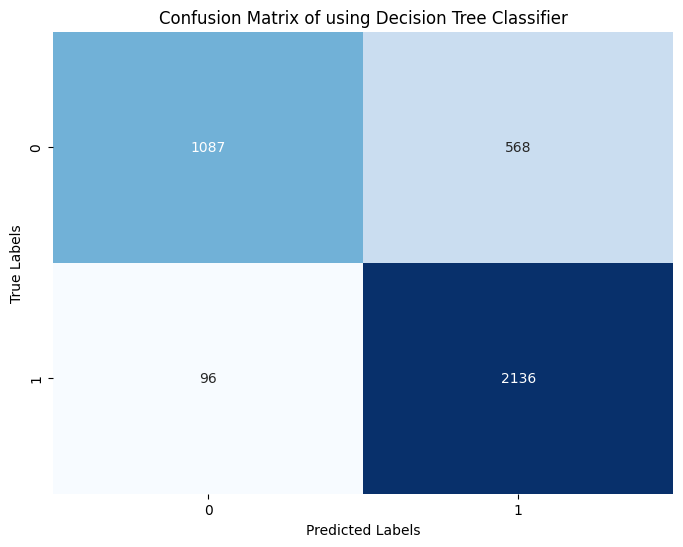

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

####`3.4. TF-IDF`

In [ ]:
X = data["full_name"]
y = data["gender"]

`Term frequency-inverse document frequency (Tf-Idf) là một trong những phương pháp
được sử dụng rộng rãi hiện nay trong lĩnh vực xử lý dữ liệu văn bản. Tf-Idf thể hiện
mức độ quan trọng của một từ trong văn bản mà văn bản đang xét nằm trong một tập
hợp các văn bản.`

`Trong thư viện sklearn.feature_extraction.text có một hàm là TfidfVectorizer(), ta dùng hàm này để áp dụng mô hình TF-IDF cho đồ án.`



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

`Biến đổi dữ liệu văn bản thành ma trận đếm`

In [ ]:
tf_v= tfidf.fit_transform(np.array(X))

In [ ]:
print(X)

1           Bùi Dương Thảo Vy
2                 Lưu Thế Huy
4             Dương Minh Long
5              Trần Mai Khanh
6        Nguyễn Thị Hồng Diệp
                 ...         
28794      Phạm Đoàn Bảo Châu
28796        Huỳnh Thu Phương
28797          Mai Nguyệt Lan
28798           Hà Thanh Ngân
28800        Vũ Hoàng Thúy Vy
Name: full_name, Length: 19431, dtype: object


`Hiển thị từ điển từ`

In [ ]:
print(tfidf.vocabulary_)

{'bùi': 59, 'dương': 234, 'thảo': 1156, 'vy': 1404, 'lưu': 588, 'thế': 1169, 'huy': 315, 'minh': 632, 'long': 540, 'trần': 1271, 'mai': 624, 'khanh': 440, 'nguyễn': 711, 'thị': 1172, 'hồng': 404, 'diệp': 204, 'thi': 1078, 'ngọc': 728, 'thái': 1119, 'tường': 1335, 'lê': 568, 'trúc': 1256, 'quỳnh': 967, 'ngô': 720, 'đức': 1564, 'hoàng': 309, 'tấn': 1343, 'đào': 1505, 'hiếu': 290, 'thạch': 1150, 'kim': 473, 'yến': 1459, 'võ': 1411, 'thanh': 1073, 'phạm': 884, 'lệ': 608, 'chi': 105, 'đỗ': 1559, 'nghĩa': 696, 'đinh': 1485, 'dân': 224, 'huỳnh': 330, 'lý': 580, 'chương': 131, 'lương': 589, 'việt': 1396, 'xuân': 1451, 'trịnh': 1278, 'nhật': 784, 'trung': 1238, 'tiến': 1199, 'đạt': 1527, 'giàu': 263, 'mỹ': 678, 'linh': 528, 'phúc': 878, 'trang': 1223, 'hồ': 400, 'nhơn': 772, 'anh': 6, 'duy': 212, 'ngôn': 722, 'cao': 95, 'thiện': 1089, 'huân': 323, 'đình': 1509, 'trương': 1260, 'diệu': 205, 'hiền': 291, 'giang': 257, 'đại': 1524, 'thu': 1101, 'thủy': 1185, 'khảo': 465, 'xương': 1453, 'đoàn': 149

`Hiển thị ma trận đếm`

In [ ]:
print(tf_v)

  (0, 1404)	0.5738614176979726
  (0, 1156)	0.5000308459534245
  (0, 234)	0.4607137875855168
  (0, 59)	0.45650304741741105
  (1, 315)	0.519247657939222
  (1, 1169)	0.6036552957257374
  (1, 588)	0.604964588771033
  (2, 540)	0.677780003800137
  (2, 632)	0.4698743314549274
  (2, 234)	0.5655372481883677
  (3, 440)	0.7685421278631466
  (3, 624)	0.5299820216291684
  (3, 1271)	0.35841603542454187
  (4, 204)	0.7626436618378927
  (4, 404)	0.5171616441016305
  (4, 1172)	0.2747724299474001
  (4, 711)	0.2746244538809126
  (5, 1119)	0.5819258692021193
  (5, 728)	0.40373400312323166
  (5, 1078)	0.70594697922397
  (6, 1335)	0.6153430058766789
  (6, 711)	0.2466739664761255
  (6, 624)	0.47995851920372473
  (6, 1404)	0.574582247572405
  (7, 967)	0.6358796498738645
  :	:
  (19424, 1197)	0.629011203368437
  (19424, 1185)	0.6186114944587469
  (19424, 1073)	0.39850506597125873
  (19424, 711)	0.2507158498295417
  (19425, 556)	0.8480458384472366
  (19425, 568)	0.31919240826545203
  (19425, 728)	0.3463253487503

`Chia data thành 2 phần : 80% cho train và 20% cho test`

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42)

`Sử dụng mô hình SVM để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1655
           1       0.93      0.97      0.95      2232

    accuracy                           0.94      3887
   macro avg       0.94      0.94      0.94      3887
weighted avg       0.94      0.94      0.94      3887

F1-score of using SVM: 0.9503950834064968


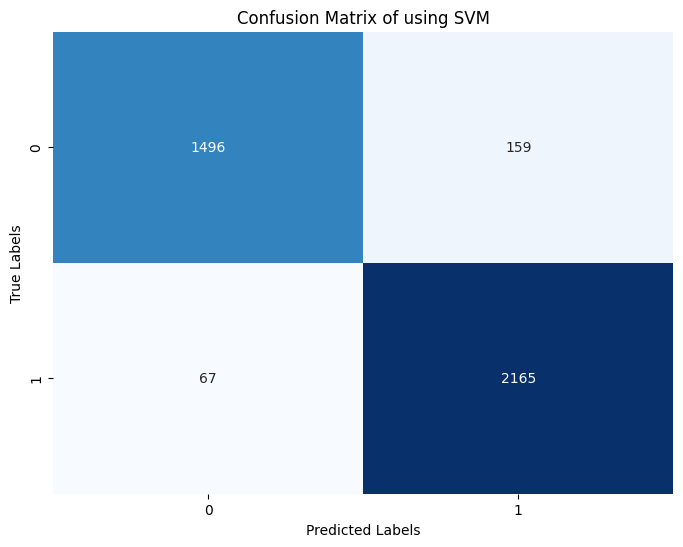

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Logistic Regression để huấn luyện mô hình và đánh giá độ chính xác của mô hình`



              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1655
           1       0.93      0.97      0.95      2232

    accuracy                           0.94      3887
   macro avg       0.94      0.94      0.94      3887
weighted avg       0.94      0.94      0.94      3887

F1-score of using Logistic Regression: 0.9501865262233925


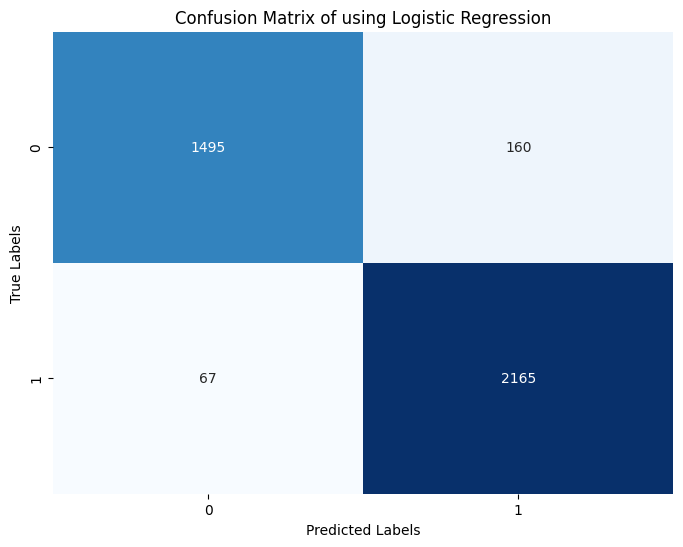

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Gaussian Naive Bayes để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.51      0.96      0.67      1655
           1       0.91      0.33      0.49      2232

    accuracy                           0.60      3887
   macro avg       0.71      0.64      0.58      3887
weighted avg       0.74      0.60      0.56      3887

F1-score of using Gaussian Naive Bayes: 0.48518762343647137


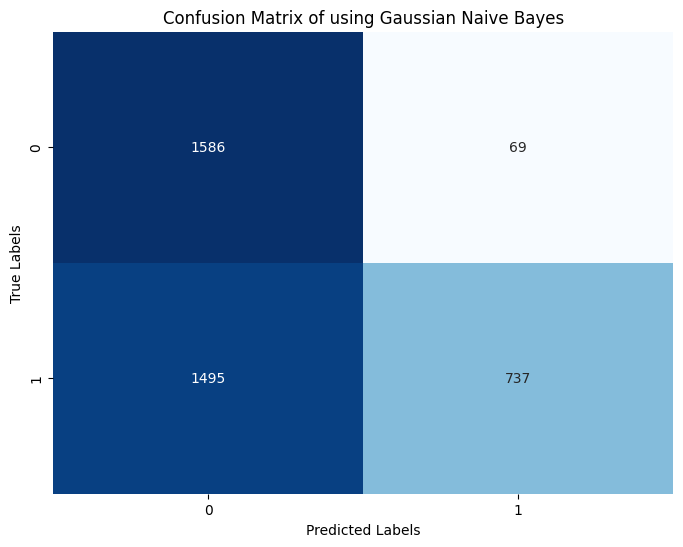

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Sử dụng mô hình Decision Tree Classifier để huấn luyện mô hình và đánh giá độ chính xác của mô hình`

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1655
           1       0.90      0.92      0.91      2232

    accuracy                           0.90      3887
   macro avg       0.89      0.89      0.89      3887
weighted avg       0.90      0.90      0.90      3887

F1-score of using Decision Tree Classifier: 0.9100222717149221


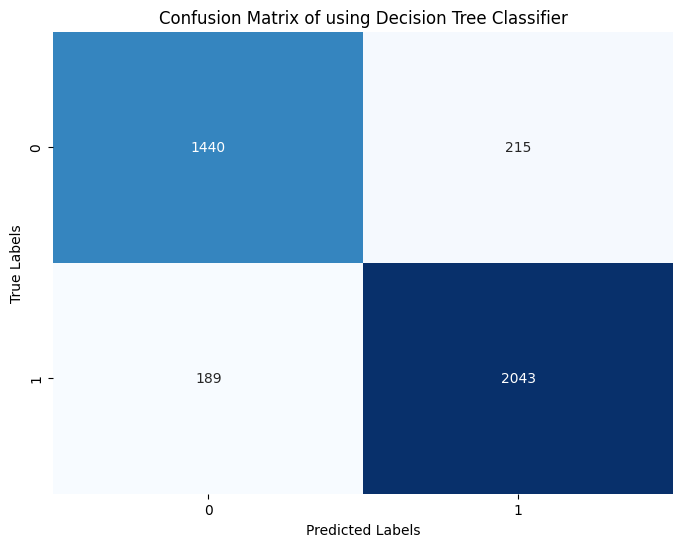

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Trường hợp đặc biệt: Bỏ họ ra khỏi data, chỉ xét tên đệm và tên. Nếu Họ và tên chỉ có 2 từ thì ta chỉ xét tên.`
`Xoá họ ra khỏi data:`

In [ ]:
X_erase_surname = []
for line in data['full_name']:
  fname = line
  middle_name, name = separate_full_name(fname)
  if middle_name != "":
    X_erase_surname.append(middle_name + " " + name)
  else:
    X_erase_surname.append(name)
print(X_erase_surname)

['Thảo Vy', 'Thế Huy', 'Minh Long', 'Mai Khanh', 'Hồng Diệp', 'Ngọc Thái', 'Tường Vy', 'Trúc Quỳnh', 'Minh Đức', 'Ngọc Tấn', 'Minh Hiếu', 'Kim Yến', 'Thị Thanh', 'Lệ Chi', 'Tấn Nghĩa', 'Kim Dân', 'Minh Chương', 'Thị Việt', 'Xuân Việt', 'Nhật Huy', 'Đức Trung', 'Tiến Đạt', 'Ngọc Giàu', 'Mỹ Linh', 'Phúc', 'Yến Ngọc', 'Thị Trang', 'Hiếu Nhơn', 'Anh Hiếu', 'Thị Trang', 'Anh Duy', 'Thanh Ngôn', 'Thiện Huân', 'Đình Đức', 'Diệu Hiền', 'Đại Nghĩa', 'Thu Thủy', 'Khảo Xương', 'Anh Tú', 'Sec Váy', 'Huỳnh Duyên', 'Mỹ Uyên', 'Tiến Nam', 'Thanh Thanh', 'Thiên Phước', 'Xuân Tùng', 'Huy Phong', 'Như Minh', 'Thanh Quí', 'Quang Hào', 'Thành Đạt', 'Bích Trúc', 'Trung Dũng', 'Ngọc Công', 'Thị Triều', 'Mỹ Phương', 'Hoàng Anh', 'Thảo Nguyên', 'Huỳnh Như', 'Tuấn Sang', 'Thu Huyền', 'Kim Ngân', 'Hải Đăng', 'Trọng Khánh', 'Thanh Toàn', 'Nhựt Tân', 'Ái Liên', 'Kiều Diễm', 'Minh Thiên', 'Hồng Phi', 'Minh Thoại', 'Hải Thắng', 'Công Danh', 'Mạnh Hùng', 'Ngọc Thuận', 'Song Luân', 'Xuân Tuyền', 'Quý Tài', 'Khánh Ngọ

`Tổng hợp lại những bước ở trên trong 1 đoạn code`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
tfidf = TfidfVectorizer()
tf_v= tfidf.fit_transform(X_erase_surname)
X_train, X_test, y_train, y_test = train_test_split(tf_v, y, test_size=0.2, random_state=42)

`SVM`

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1655
           1       0.92      0.94      0.93      2232

    accuracy                           0.92      3887
   macro avg       0.92      0.91      0.92      3887
weighted avg       0.92      0.92      0.92      3887

F1-score of using SVM: 0.92989417989418


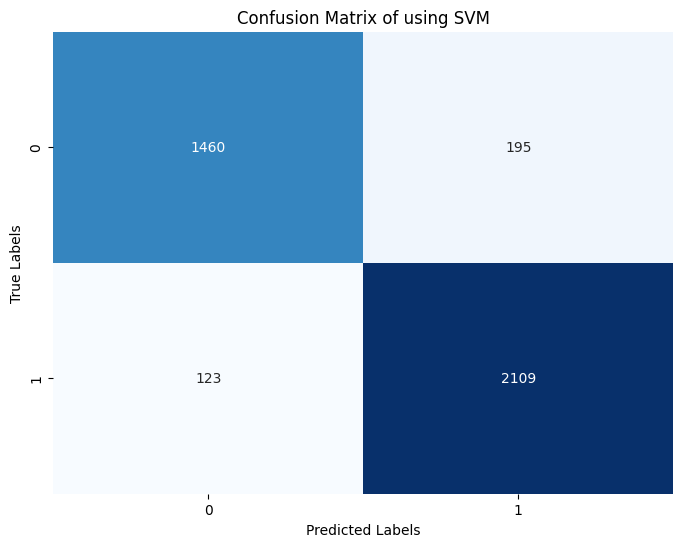

In [ ]:
# Huấn luyện mô hình SVM
clf = SVC()
clf.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using SVM:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Logistic Regression`

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1655
           1       0.92      0.95      0.93      2232

    accuracy                           0.92      3887
   macro avg       0.92      0.92      0.92      3887
weighted avg       0.92      0.92      0.92      3887

F1-score of using Logistic Regression: 0.9323076923076923


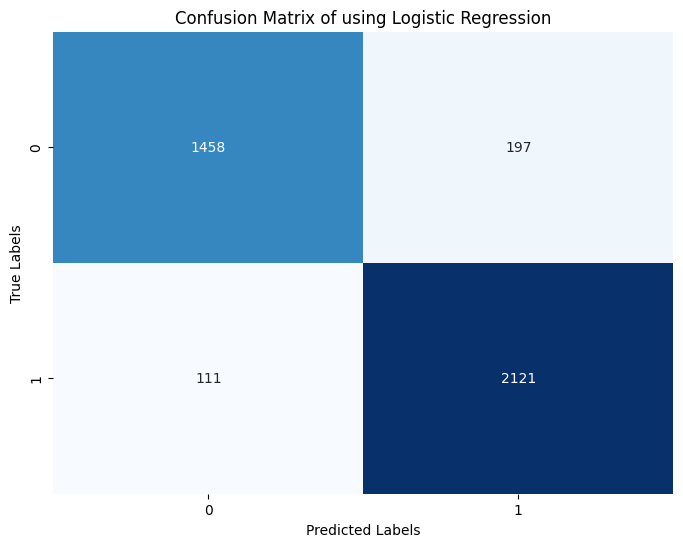

In [ ]:
# Huấn luyện mô hình Logistic Regression
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_LR.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Gaussian Naive Bayes`

              precision    recall  f1-score   support

           0       0.52      0.97      0.67      1655
           1       0.93      0.33      0.49      2232

    accuracy                           0.60      3887
   macro avg       0.72      0.65      0.58      3887
weighted avg       0.76      0.60      0.57      3887

F1-score of using Gaussian Naive Bayes: 0.48859504132231407


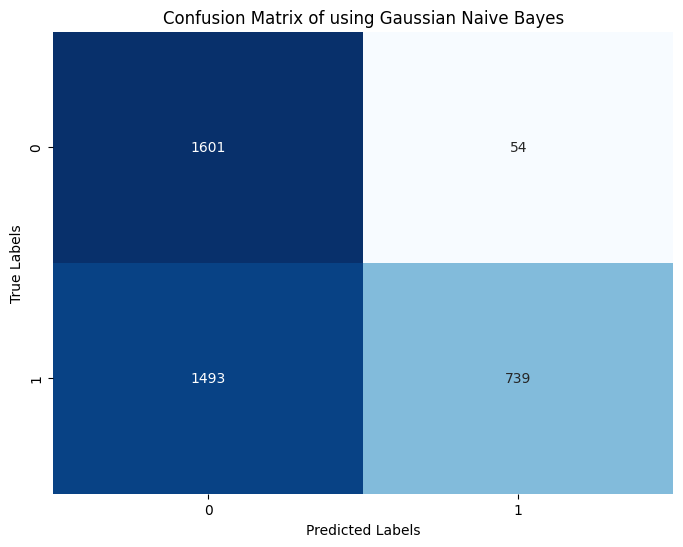

In [ ]:
# Huấn luyện mô hình Gaussian Naive Bayes
clf_NB = GaussianNB()
clf_NB.fit(X_train.toarray(), y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_NB.predict(X_test.toarray())

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Gaussian Naive Bayes:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Gaussian Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

`Decision Tree Classifier`

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1655
           1       0.91      0.91      0.91      2232

    accuracy                           0.89      3887
   macro avg       0.89      0.89      0.89      3887
weighted avg       0.89      0.89      0.89      3887

F1-score of using Decision Tree Classifier: 0.9068880412833746


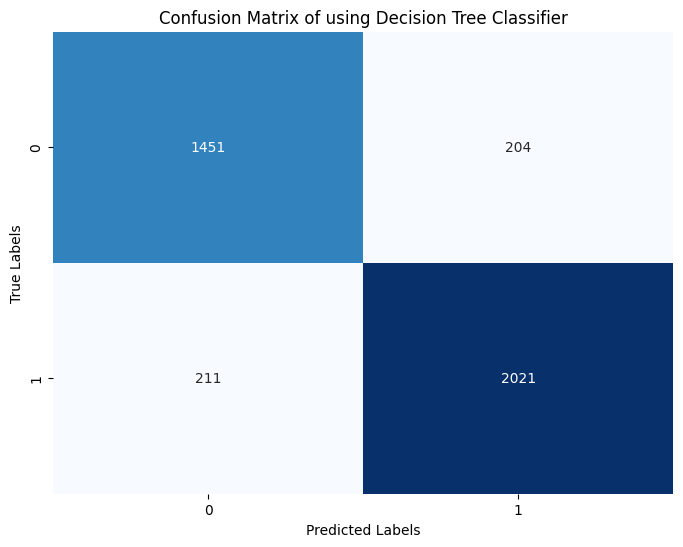

In [ ]:
# Huấn luyện mô hình Decision Tree Classifier
clf_Tree = DecisionTreeClassifier()
clf_Tree.fit(X_train, y_train)

# Dự đoán y từ bộ test cho trước
y_pred = clf_Tree.predict(X_test)

# Đánh giá độ chính xác
print(classification_report(y_test, y_pred))
print("F1-score of using Decision Tree Classifier:", f1_score(y_test, y_pred))

# Minh hoạ qua confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix of using Decision Tree Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##**`IV. Kết luận`**


`Sau khi đã xem xét và áp dụng tất cả những gì mà nhóm đã nghiên cứu và thực hiện
được. Kết quả thu được tốt nhất của nhóm đó là f1-score đạt max là 95.13%, sử dụng
mô hình SVM, trích chọn đặc trưng là Bag-of-words và không bỏ đi phần họ trong họ
và tên.`

`Ngoài ra, khi thử bỏ phần họ trong họ và tên đi thì performance của các mô hình máy
học kết hợp các trích chọn đặc trưng cho văn bản lại bị giảm đi.`
